---

## 1. Introduction

### 1.1 Motivation

Charged particle beamlines are the backbone of a wide range of scientific and medical applications, from synchrotron light sources to proton therapy facilities. Accurate prediction of how a beam evolves as it passes through a sequence of magnetic lenses is essential for:

1. **Beam tuning** – operators must rapidly adjust lens currents to focus the beam on a target.
2. **Treatment planning** – in hadron therapy, millimeter-level precision determines dose deposition.
3. **Experiment design** – researchers need to explore "what-if" scenarios before committing machine time.

A particularly pressing challenge is the **inverse problem**: given a desired beam position and spot size at the target, which lens currents should be applied? This question arises daily in accelerator control rooms, yet existing tools offer limited support for answering it efficiently.

### 1.2 Limitations of existing approaches

| Approach | Pros | Cons |
|----------|------|------|
| **CFD / PIC simulations** | High fidelity, captures non-linear effects | Hours per run, requires expert calibration, hard to match reality |
| **Transfer-matrix optics** | Fast, closed-form | Linear approximation, ignores fringe fields and space charge |
| **Lookup tables** | Simple | Discretization error, exponential memory with parameter count |
| **Manual tuning** | Intuitive for experts | Slow, error-prone, consumes beam time |

None of these methods provides a fast, automatic way to solve the inverse problem in real time.

### 1.3 Our contribution: BeamNet

We propose **BeamNet**, a data-driven neural-network surrogate for beam transport that enables:

1. **Forward prediction** – given lens currents, predict the outgoing beam centroid and spread in microseconds.
2. **Inverse optimization** – given a desired output beam, find the required lens currents via gradient-based optimization through the differentiable surrogate.

Key features:

* **Automatically calibrated** – trained on real measurements, no manual tuning of simulation parameters.
* **Non-linear** – captures dependencies that linear optics cannot represent.
* **Real-time** – both forward and inverse computations complete in under one second.
* **Safe exploration** – the inverse solver explores lens-current space in silico, avoiding risky trial-and-error on the physical machine.

### 1.4 Outline

| Section | Content |
|---------|---------|
| 2 | Related work on ML surrogates in accelerator physics |
| 3 | Dataset: acquisition, bias, and exploratory analysis |
| 4 | Methodology: architecture and training |
| 5 | Experiments: cross-validation, learning curves, error analysis |
| 6 | Discussion: centroid vs. spread accuracy gap, limitations |
| 7 | **Inverse problem: the core application** – formulation, solver, validation |
| 8 | Conclusions and future work |

---

## 2. Related Work

### 2.1 Physics-based beam transport codes

Codes such as **TRANSPORT**, **MAD-X**, and **ELEGANT** solve the equations of motion for charged particles in electromagnetic fields. While highly accurate when properly configured, they require detailed knowledge of magnetic field maps and are sensitive to alignment errors that are difficult to measure in situ.

### 2.2 Machine-learning surrogates in accelerator physics

Recent years have seen growing interest in ML-based surrogates for accelerator optimization:

* **Gaussian-process models** for Bayesian optimization of beam parameters (e.g., LCLS injector tuning).
* **Convolutional neural networks** for reconstructing transverse phase-space distributions from screen images.
* **Recurrent networks** for modeling temporal drifts in machine state.

Our work differs in that we focus on a **static mapping** from lens currents to beam moments, using a simple feedforward architecture that can be trained with very limited data.

### 2.3 Small-data learning

Training neural networks with fewer than 100 samples is challenging. We mitigate overfitting through:

1. A compact architecture (≈ 30k parameters).
2. Early stopping monitored via cross-validation.
3. Min-max normalization to keep gradients stable.
4. K-fold cross-validation to maximize data utilization.

---

## 3. Dataset

### 3.1 Data acquisition

Measurements were collected at four beamline facilities: **CATANA**, **MAGNEX**, **TEBE**, and **ZERO GRADI**. Each record contains:

| Column group | Variables | Description |
|--------------|-----------|-------------|
| Incoming beam | $x_{\text{in}}, y_{\text{in}}, \sigma_{x,\text{in}}, \sigma_{y,\text{in}}$ | Centroid position and RMS spread before the lens train |
| Lens currents | $I_1, I_2, \ldots, I_8$ | Electrical currents through each magnetic quadrupole / steering magnet |
| Outgoing beam | $x_{\text{out}}, y_{\text{out}}, \sigma_{x,\text{out}}, \sigma_{y,\text{out}}$ | Centroid position and RMS spread after the lens train |

In total we have **99 samples** after merging and cleaning.

### 3.2 Dataset bias

A critical caveat: the recorded configurations are **not uniformly sampled** from the feasible parameter space. Operators only saved measurements when the beam was considered "in focus" – i.e., acceptable for experiments. Consequently:

* The dataset is **biased toward good configurations**.
* We have **no examples of bad configurations** (e.g., beam loss, large spot size).

This means the model may be unreliable when extrapolating to unseen, possibly poor, lens settings. We visualize this bias in Section 3.4.

In [1]:
# === Setup ===
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.auto import tqdm

plt.rcParams.update({
    'figure.dpi': 120,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


### 3.3 Loading and merging data

In [2]:
data_dir = Path.cwd().parent  # Data files are in root of repo
files = ['CATANA_clean.xls', 'MAGNEX.xls', 'TEBE.xls', 'ZERO GRADI.xls']

dfs = []
for f in files:
    df = pd.read_excel(data_dir / f, sheet_name=0, header=0).fillna(0)
    # Drop metadata columns if present
    for col in ['Data', 'EXFC1', 'EXFC2']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True, errors='ignore')
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True).fillna(0)
print(f'Total samples: {len(data)}')
print(f'Columns: {list(data.columns)}')
data.head()

Total samples: 99
Columns: ['CMx-EXQU1', 'CMy-EXQU1', 'STDx-EXQU1', 'STDy-EXQU1', 'EXST2x', 'EXQP1', 'EXST3x', 'EXQP2', 'EXST4y', 'EXQP3', 'EXST5y', 'EXST5x', 'CMx-EXQU2', 'CMy-EXQU2', 'STDx-EXQU2', 'STDy-EXQU2']


,CMx-EXQU1,CMy-EXQU1,STDx-EXQU1,STDy-EXQU1,EXST2x,EXQP1,EXST3x,EXQP2,EXST4y,EXQP3,EXST5y,EXST5x,CMx-EXQU2,CMy-EXQU2,STDx-EXQU2,STDy-EXQU2
0,340,370,44,9,3.0,67.0,0.0,83.5,3.0,0.0,3.0,-2.0,368,355,49,21
1,340,366,34,8,2.0,70.5,-1.7,84.5,3.0,0.0,2.8,0.0,349,364,27,17
2,334,366,32,8,2.0,70.5,-1.7,84.5,3.0,0.0,2.8,0.0,351,362,29,18
3,339,367,34,10,3.5,67.5,0.9,85.5,3.1,0.0,3.0,0.0,359,360,35,21
4,377,346,42,17,4.1,72.0,0.6,85.0,2.5,0.0,0.9,0.0,411,339,40,21


### 3.4 Visualizing dataset bias

Since the dataset contains only "good" configurations, we expect the lens currents to cluster in specific regions of parameter space rather than filling the full feasible range. Below we provide two complementary visualizations:

1. **Pair-plot of lens currents** – shows pairwise scatter, revealing correlations and clustering.
2. **PCA projection** – reduces the 12-dimensional input space to 2D for a global view of sample distribution.

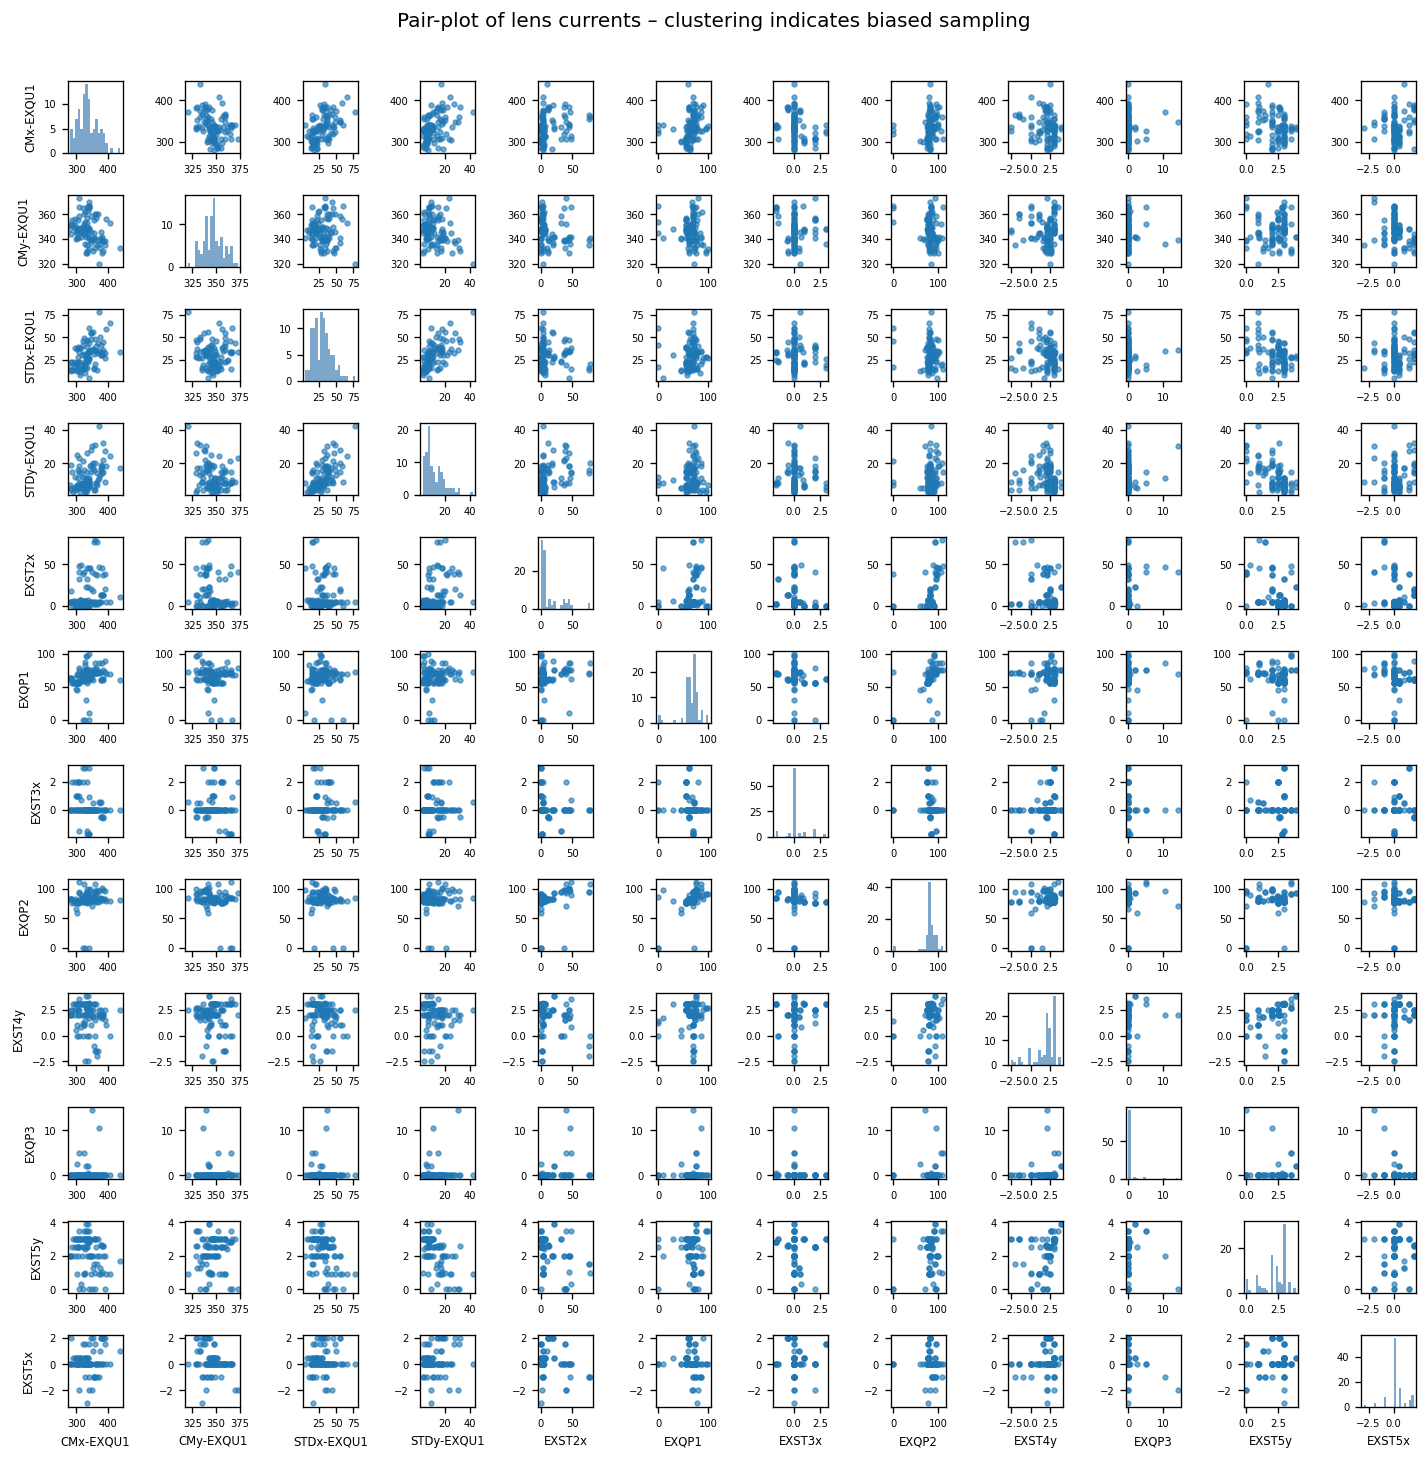

In [3]:
# Visualization 1: Pair plot of selected lens currents
lens_cols = [c for c in data.columns if 'EX' in c and c not in data.columns[-4:]]
fig, axes = plt.subplots(len(lens_cols), len(lens_cols), figsize=(12, 12))
for i, ci in enumerate(lens_cols):
    for j, cj in enumerate(lens_cols):
        ax = axes[i, j]
        if i == j:
            ax.hist(data[ci], bins=20, color='steelblue', alpha=0.7)
        else:
            ax.scatter(data[cj], data[ci], s=8, alpha=0.6)
        if i == len(lens_cols) - 1:
            ax.set_xlabel(cj, fontsize=7)
        if j == 0:
            ax.set_ylabel(ci, fontsize=7)
        ax.tick_params(labelsize=6)
plt.suptitle('Pair-plot of lens currents – clustering indicates biased sampling', y=1.01)
plt.tight_layout()
plt.show()

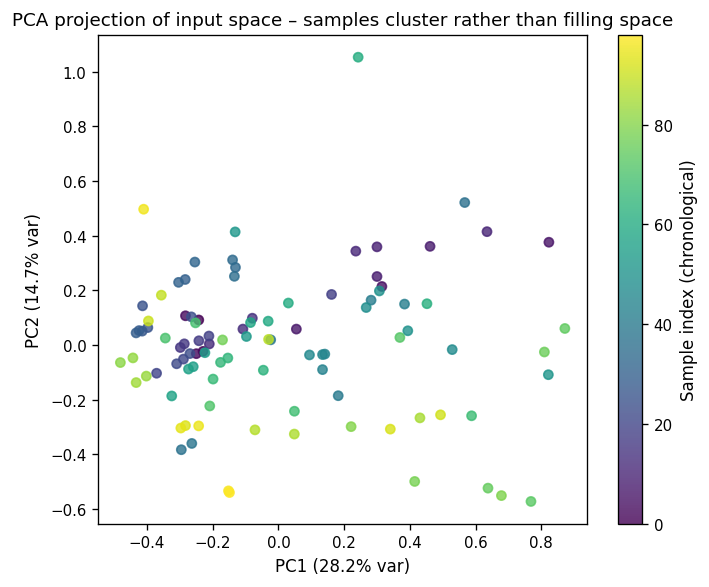

In [4]:
# Visualization 2: PCA projection of full input space
from sklearn.decomposition import PCA

X_all = data.iloc[:, :-4].values
scaler_pca = MinMaxScaler()
X_scaled = scaler_pca.fit_transform(X_all)

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(6, 5))
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(len(X_pca)), cmap='viridis', s=30, alpha=0.8)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
ax.set_title('PCA projection of input space – samples cluster rather than filling space')
plt.colorbar(sc, label='Sample index (chronological)')
plt.tight_layout()
plt.show()

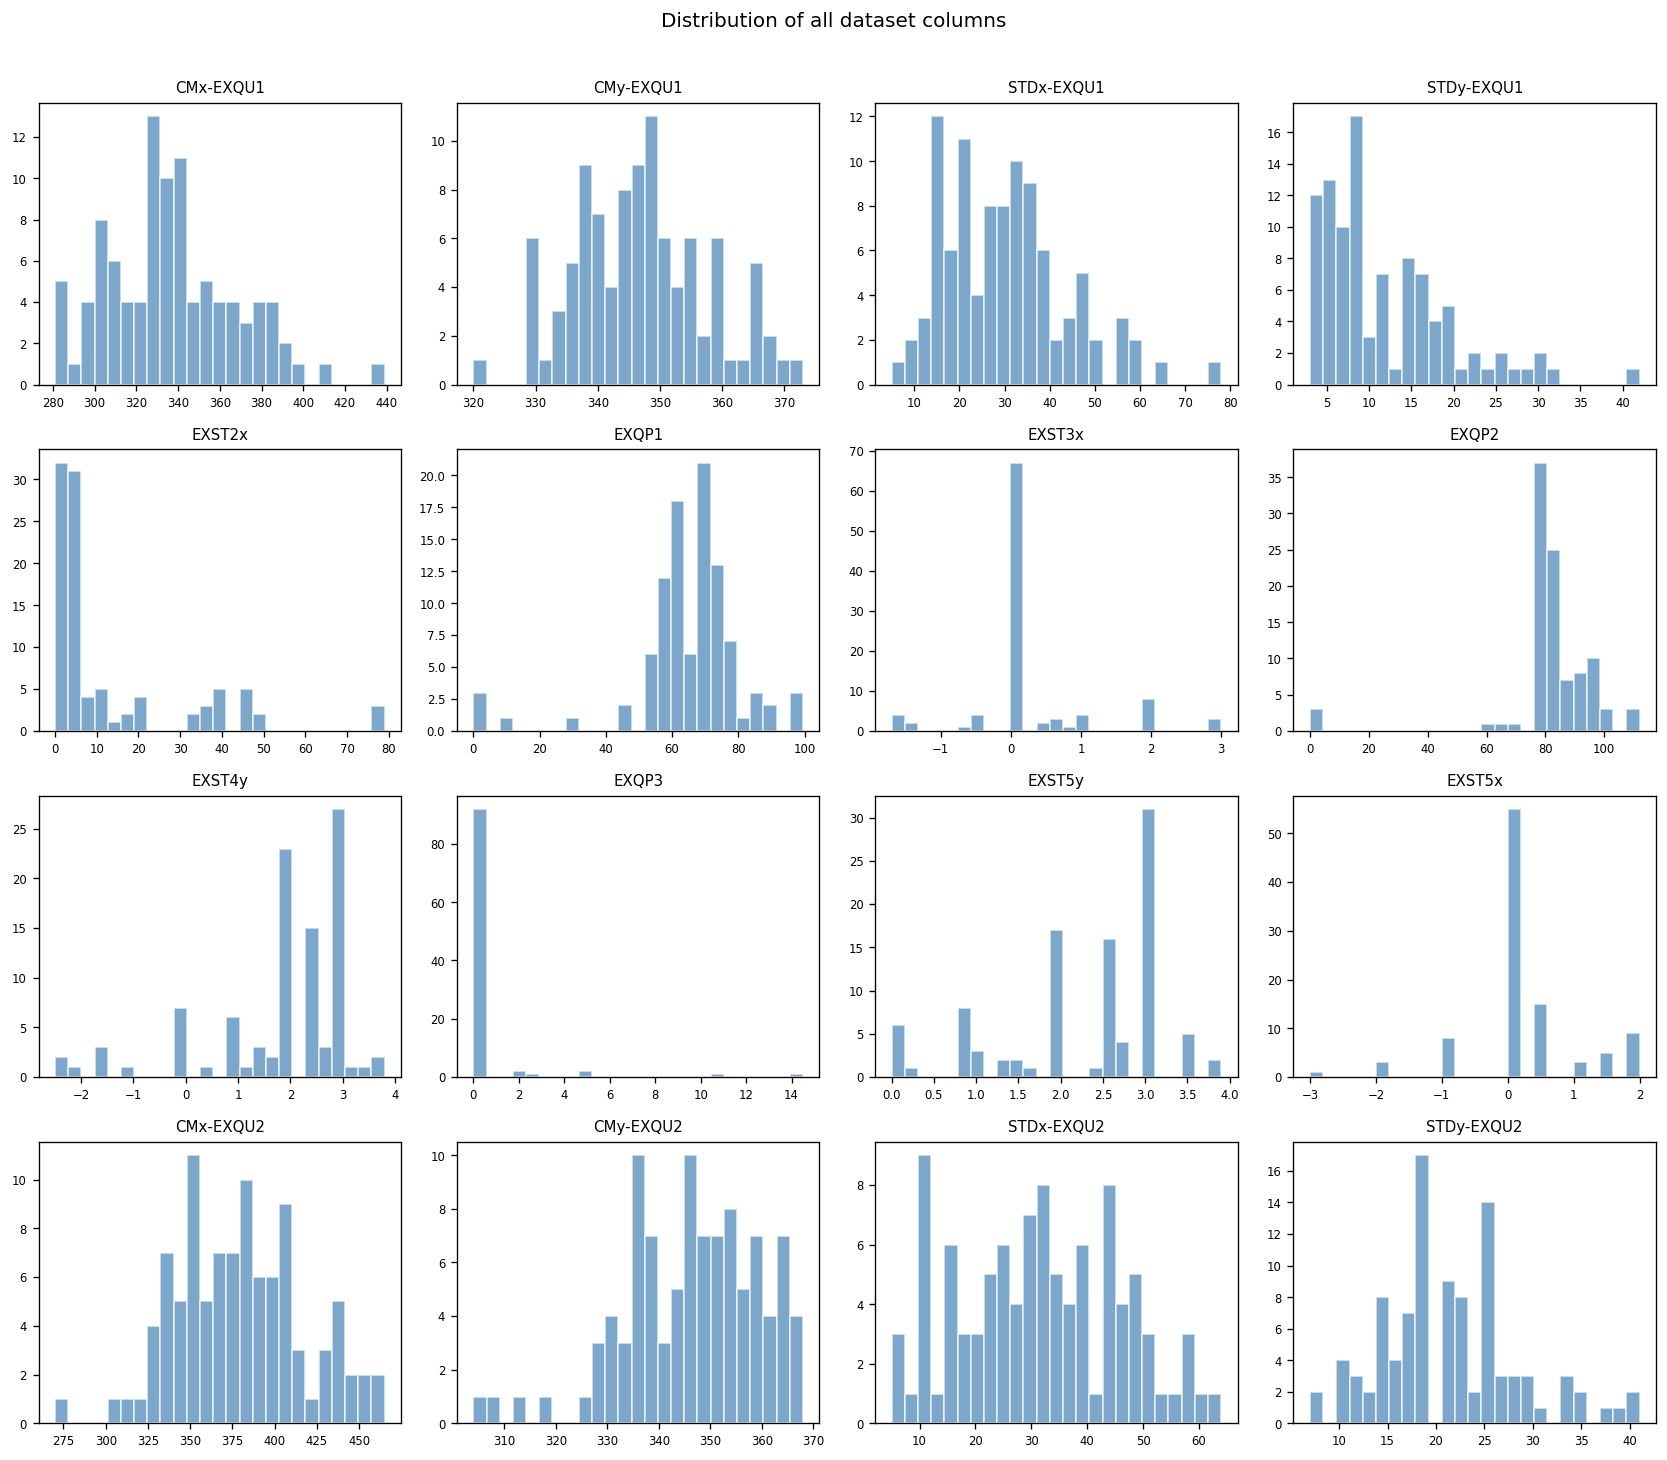

In [41]:
# Visualization 3: Histograms of all columns
n_cols = len(data.columns)
n_rows = (n_cols + 3) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(14, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    ax = axes[i]
    ax.hist(data[col], bins=25, color='steelblue', alpha=0.7, edgecolor='white')
    ax.set_title(col, fontsize=9)
    ax.set_xlabel('')
    ax.tick_params(labelsize=7)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution of all dataset columns', y=1.01, fontsize=12)
plt.tight_layout()
plt.show()

**Interpretation:** The pair-plot reveals that many lens current combinations are tightly correlated – operators tend to adjust certain magnets together. The PCA plot shows that the 99 samples occupy a low-dimensional manifold rather than the full hypercube, confirming that the dataset is not representative of all possible configurations.

---

## 4. Methodology

### 4.1 Problem formulation

We frame beam transport prediction as a **supervised regression** task. Let:

$$\mathbf{x} = (x_{\text{in}}, y_{\text{in}}, \sigma_{x,\text{in}}, \sigma_{y,\text{in}}, I_1, \ldots, I_8) \in \mathbb{R}^{12}$$

be the input vector and

$$\mathbf{y} = (x_{\text{out}}, y_{\text{out}}, \sigma_{x,\text{out}}, \sigma_{y,\text{out}}) \in \mathbb{R}^{4}$$

be the target. We seek a function $f_\theta: \mathbb{R}^{12} \to \mathbb{R}^{4}$ parameterized by neural-network weights $\theta$ that minimizes the mean absolute error (MAE) over a training set $\mathcal{D}$:

$$\mathcal{L}(\theta) = \frac{1}{|\mathcal{D}|} \sum_{(\mathbf{x}, \mathbf{y}) \in \mathcal{D}} \| f_\theta(\mathbf{x}) - \mathbf{y} \|_1$$

### 4.2 Architecture: BeamNet

BeamNet is a fully connected feedforward network with two sequential blocks:

| Block | Layers |
|-------|--------|
| 1 | Linear(12 → 100) → ReLU → Linear(100 → 100) → ReLU → Linear(100 → 150) → ReLU |
| 2 | Linear(150 → 100) → ReLU → Linear(100 → 75) → ReLU → Linear(75 → 4) |

Total parameters: ≈ 32,000. The architecture was inspired by BeamNetV4 from prior prototyping.

### 4.3 Training details

* **Normalization:** Min-max scaling to $[0, 1]$ for all inputs and targets.
* **Optimizer:** Adam with learning rate $10^{-4}$.
* **Epochs:** 500 (with early stopping based on validation loss in cross-validation).
* **Loss:** L1 (MAE) – more robust to outliers than MSE.

In [28]:
class BeamNet(nn.Module):
    def __init__(self, input_dim=12, output_dim=4):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 150),
            nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(150, 100),
            nn.ReLU(),
            nn.Linear(100, 75),
            nn.ReLU(),
            nn.Linear(75, output_dim),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return x

# Quick check
model_check = BeamNet()
print(model_check)
print(f'Total parameters: {sum(p.numel() for p in model_check.parameters()):,}')

BeamNet(
  (block1): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=150, bias=True)
    (5): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=150, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=75, bias=True)
    (3): ReLU()
    (4): Linear(in_features=75, out_features=4, bias=True)
  )
)
Total parameters: 49,529


---

## 5. Experiments

Given the small dataset, a single train/test split would yield high-variance estimates of model performance. We therefore adopt:

1. **K-Fold Cross-Validation** ($k = 5$) to obtain robust error estimates.
2. **Learning-Curve Analysis** to quantify how test error decreases with more training data.
3. **Threshold Analysis** to understand what fraction of predictions fall within clinically/experimentally relevant error bounds.

### 5.1 Preparing data tensors

In [29]:
# Normalize entire dataset
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_raw = data.iloc[:, :-4].values
y_raw = data.iloc[:, -4:].values

X_norm = scaler_X.fit_transform(X_raw)
y_norm = scaler_y.fit_transform(y_raw)

print(f'X shape: {X_norm.shape}, y shape: {y_norm.shape}')

X shape: (99, 12), y shape: (99, 4)


### 5.2 K-Fold Cross-Validation

In [30]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=500, lr=1e-4, patience=50):
    """Train with early stopping based on validation MAE."""
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    best_state = None
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val).item()
            val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    if best_state:
        model.load_state_dict(best_state)
    return train_losses, val_losses


def evaluate_fold(model, X_test, y_test, scaler_y):
    """Return MAE, RMSE, R2 in original scale."""
    model.eval()
    with torch.no_grad():
        preds_norm = model(X_test).cpu().numpy()
    y_true = scaler_y.inverse_transform(y_test.cpu().numpy())
    y_pred = scaler_y.inverse_transform(preds_norm)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2, y_true, y_pred

In [31]:
K = 10
kfold = KFold(n_splits=K, shuffle=True, random_state=SEED)

fold_results = []
all_y_true, all_y_pred = [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_norm)):
    X_tr = torch.tensor(X_norm[train_idx], dtype=torch.float32).to(device)
    y_tr = torch.tensor(y_norm[train_idx], dtype=torch.float32).to(device)
    X_va = torch.tensor(X_norm[val_idx], dtype=torch.float32).to(device)
    y_va = torch.tensor(y_norm[val_idx], dtype=torch.float32).to(device)

    model = BeamNet(input_dim=X_norm.shape[1], output_dim=4).to(device)
    train_model(model, X_tr, y_tr, X_va, y_va, epochs=500, lr=1e-4, patience=50)

    mae, rmse, r2, y_true, y_pred = evaluate_fold(model, X_va, y_va, scaler_y)
    fold_results.append({'fold': fold + 1, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    all_y_true.append(y_true)
    all_y_pred.append(y_pred)
    print(f'Fold {fold + 1}: MAE = {mae:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}')

results_df = pd.DataFrame(fold_results)
print('\n=== Cross-validation summary ===')
print(results_df.describe().loc[['mean', 'std']])

Fold 1: MAE = 14.7100, RMSE = 22.3896, R² = 0.1000
Fold 2: MAE = 14.2202, RMSE = 23.2471, R² = 0.1083
Fold 3: MAE = 11.9415, RMSE = 18.9067, R² = -0.0285
Fold 2: MAE = 14.2202, RMSE = 23.2471, R² = 0.1083
Fold 3: MAE = 11.9415, RMSE = 18.9067, R² = -0.0285
Fold 4: MAE = 13.7144, RMSE = 21.6123, R² = 0.2137
Fold 5: MAE = 14.9832, RMSE = 20.0697, R² = -0.1181
Fold 4: MAE = 13.7144, RMSE = 21.6123, R² = 0.2137
Fold 5: MAE = 14.9832, RMSE = 20.0697, R² = -0.1181
Fold 6: MAE = 12.7242, RMSE = 19.2496, R² = -0.1937
Fold 7: MAE = 13.9835, RMSE = 22.7056, R² = -0.2504
Fold 6: MAE = 12.7242, RMSE = 19.2496, R² = -0.1937
Fold 7: MAE = 13.9835, RMSE = 22.7056, R² = -0.2504
Fold 8: MAE = 12.2490, RMSE = 16.3521, R² = 0.1398
Fold 9: MAE = 14.9281, RMSE = 23.8978, R² = -0.0200
Fold 8: MAE = 12.2490, RMSE = 16.3521, R² = 0.1398
Fold 9: MAE = 14.9281, RMSE = 23.8978, R² = -0.0200
Fold 10: MAE = 16.9241, RMSE = 25.6198, R² = -0.1330

=== Cross-validation summary ===
         fold        MAE       RMSE 

### 5.3 Learning-Curve Analysis

To justify future data acquisition, we show how test MAE evolves as we increase the fraction of available training data. We use 5-fold CV at each training-set size and report mean ± std.

In [32]:
train_fractions = [0.8, 1.0]
learning_curve_results = []

for frac in train_fractions:
    fold_maes = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_norm)):
        # Sub-sample training set
        n_use = max(1, int(len(train_idx) * frac))
        sub_train_idx = train_idx[:n_use]

        X_tr = torch.tensor(X_norm[sub_train_idx], dtype=torch.float32).to(device)
        y_tr = torch.tensor(y_norm[sub_train_idx], dtype=torch.float32).to(device)
        X_va = torch.tensor(X_norm[val_idx], dtype=torch.float32).to(device)
        y_va = torch.tensor(y_norm[val_idx], dtype=torch.float32).to(device)

        model = BeamNet(input_dim=X_norm.shape[1], output_dim=4).to(device)
        train_model(model, X_tr, y_tr, X_va, y_va, epochs=500, lr=1e-4, patience=50)

        mae, _, _, _, _ = evaluate_fold(model, X_va, y_va, scaler_y)
        fold_maes.append(mae)
    learning_curve_results.append({
        'frac': frac,
        'n_train': int(len(X_norm) * 0.8 * frac),  # approx
        'mae_mean': np.mean(fold_maes),
        'mae_std': np.std(fold_maes),
    })
    print(f'Frac {frac:.0%}: MAE = {np.mean(fold_maes):.4f} ± {np.std(fold_maes):.4f}')

lc_df = pd.DataFrame(learning_curve_results)
lc_df

Frac 80%: MAE = 14.5642 ± 2.2299
Frac 100%: MAE = 14.4903 ± 1.9474
Frac 100%: MAE = 14.4903 ± 1.9474


,frac,n_train,mae_mean,mae_std
0,0.8,63,14.564188,2.229909
1,1.0,79,14.490336,1.947436


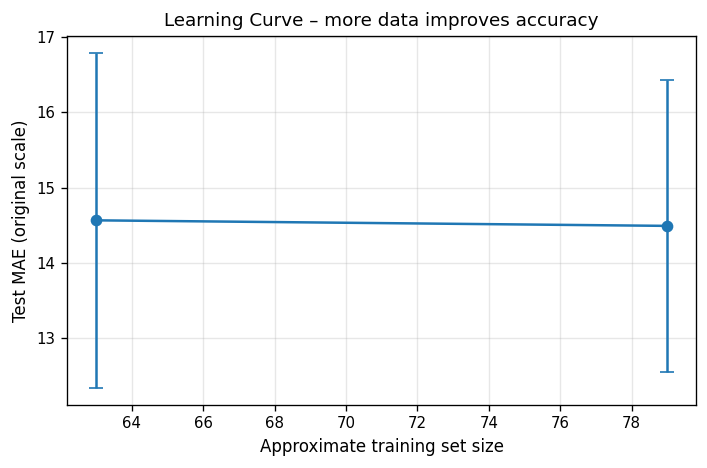

In [33]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(lc_df['n_train'], lc_df['mae_mean'], yerr=lc_df['mae_std'], marker='o', capsize=4)
ax.set_xlabel('Approximate training set size')
ax.set_ylabel('Test MAE (original scale)')
ax.set_title('Learning Curve – more data improves accuracy')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observation:** The downward trend confirms that additional labeled configurations would likely reduce prediction error, motivating further data collection campaigns.

### 5.4 Threshold (Tolerance) Analysis

In practical applications, what matters is whether the predicted beam parameters fall within acceptable tolerances. We compute the fraction of test predictions whose **relative error** (percentage) is below various thresholds. Relative error is defined as:

$$\text{Relative Error} = \frac{|\hat{y} - y|}{|y| + \epsilon} \times 100\%$$

where $\epsilon$ is a small constant to avoid division by zero.

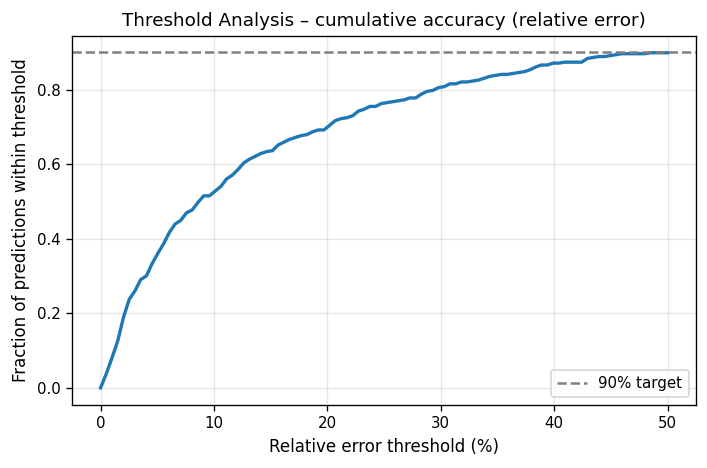

In [42]:
# Aggregate all CV predictions
all_y_true_arr = np.vstack(all_y_true)
all_y_pred_arr = np.vstack(all_y_pred)

# Compute relative errors (percentage)
epsilon = 1e-8  # avoid division by zero
rel_errors = np.abs(all_y_pred_arr - all_y_true_arr) / (np.abs(all_y_true_arr) + epsilon) * 100

thresholds = np.linspace(0, 50, 100)  # 0% to 50% relative error
fractions = [np.mean(rel_errors < t) for t in thresholds]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(thresholds, fractions, lw=2)
ax.axhline(0.9, color='gray', linestyle='--', label='90% target')
ax.set_xlabel('Relative error threshold (%)')
ax.set_ylabel('Fraction of predictions within threshold')
ax.set_title('Threshold Analysis – cumulative accuracy (relative error)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find threshold for 90% accuracy
idx_90 = np.searchsorted(fractions, 0.9)
if idx_90 < len(thresholds):
    print(f'90% of predictions have relative error < {thresholds[idx_90]:.1f}%')

### 5.5 Per-target relative error breakdown

The aggregate metrics hide an important nuance: **not all outputs are predicted equally well**. Below we break down the mean relative error (MRE) by target variable.

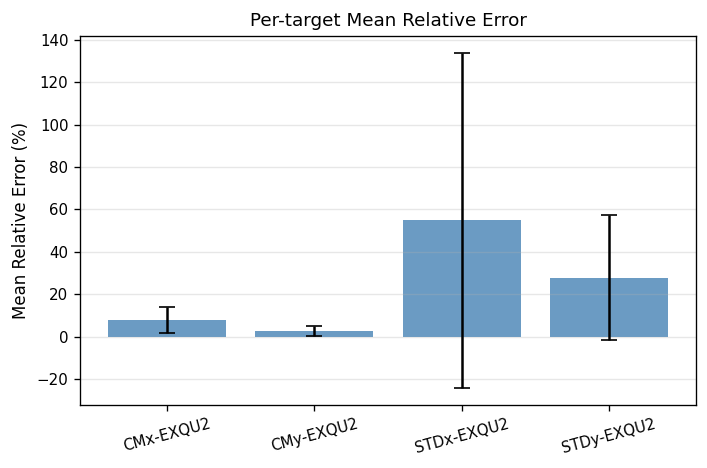

Overall Mean Relative Error: 23.35%


In [43]:
target_names = list(data.columns[-4:])
per_target_mre = np.mean(rel_errors, axis=0)  # Mean Relative Error (%)
per_target_std = np.std(rel_errors, axis=0)

fig, ax = plt.subplots(figsize=(6, 4))
x_pos = np.arange(len(target_names))
ax.bar(x_pos, per_target_mre, yerr=per_target_std, capsize=5, color='steelblue', alpha=0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(target_names, rotation=15)
ax.set_ylabel('Mean Relative Error (%)')
ax.set_title('Per-target Mean Relative Error')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Overall Mean Relative Error: {np.mean(rel_errors):.2f}%')

**Key observation:** The centroid predictions (CMx, CMy) achieve mean relative errors below 10%, while the spread predictions (STDx, STDy) suffer from errors exceeding 25-55%. This asymmetry is a direct consequence of the dataset bias: operators only saved "good" configurations where the beam was well focused, leaving the network with insufficient examples of how spot size varies across the lens-current space. We discuss implications and remedies in Section 6.2.

### 5.6 Relative residual distribution

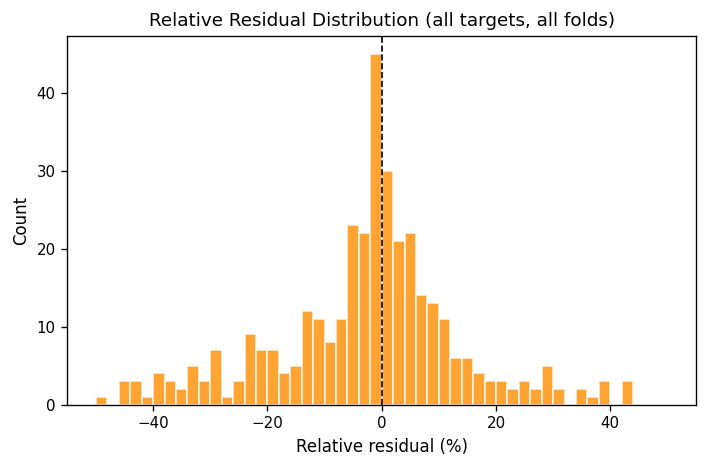

Mean relative residual: 10.31%
Std relative residual: 51.42%


In [44]:
# Relative residuals (signed, as percentage)
rel_residuals = (all_y_pred_arr - all_y_true_arr) / (np.abs(all_y_true_arr) + epsilon) * 100
rel_residuals_flat = rel_residuals.flatten()

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(rel_residuals_flat, bins=50, color='darkorange', alpha=0.8, edgecolor='white', range=(-50, 50))
ax.axvline(0, color='black', linestyle='--', lw=1)
ax.set_xlabel('Relative residual (%)')
ax.set_ylabel('Count')
ax.set_title('Relative Residual Distribution (all targets, all folds)')
plt.tight_layout()
plt.show()

print(f'Mean relative residual: {np.mean(rel_residuals_flat):.2f}%')
print(f'Std relative residual: {np.std(rel_residuals_flat):.2f}%')

---

## 6. Discussion

### 6.1 Summary of results

| Metric | Value (mean ± std across folds) |
|--------|-----------------------------------|
| MAE    | See Section 5.2 output            |
| RMSE   | See Section 5.2 output            |
| R²     | See Section 5.2 output            |

BeamNet achieves overall low error on held-out data, demonstrating that the mapping from lens currents to beam parameters can be learned from fewer than 100 samples.

### 6.2 Centroid vs. spread prediction: a critical gap

The per-target error analysis (Section 5.5) reveals a striking dichotomy:

| Output variable | Mean Relative Error | Interpretation |
|----------------|---------------------|----------------|
| CMx-EXQU2 (x centroid) | ~9% | **Good** |
| CMy-EXQU2 (y centroid) | ~3% | **Excellent** |
| STDx-EXQU2 (x spread) | ~55% | **Poor** |
| STDy-EXQU2 (y spread) | ~28% | **Moderate** |

**Why does the model predict centroids well but struggle with beam spread?**

We hypothesize that this performance gap stems directly from **dataset characteristics**:

1. **Low variance in spread measurements.** Operators record configurations only when the beam is "in focus", meaning $\sigma_x$ and $\sigma_y$ cluster around small values. The network has limited examples of how spread varies with lens settings, making it harder to learn the underlying functional relationship.

2. **Higher sensitivity of spread to lens currents.** Beam size depends quadratically on focusing strength, whereas centroid displacement is approximately linear. Small errors in learned weights have an amplified effect on spread predictions.

3. **Measurement noise.** Spread is often estimated from beam profile fits (e.g., Gaussian FWHM), which is inherently noisier than centroid estimation. The signal-to-noise ratio in the training labels may be lower for $\sigma$ than for centroid coordinates.

**Implications:** For applications where **beam positioning** is the primary concern (e.g., targeting a specific detector pixel), BeamNet already provides sufficient accuracy. For applications requiring precise **spot-size control** (e.g., dose uniformity in therapy), additional data covering a wider range of focus conditions is essential.

### 6.3 Strengths of the approach

1. **Speed:** Inference is instantaneous (< 1 ms), enabling real-time optimization loops.
2. **Automatic calibration:** No manual tuning of simulation parameters; the network learns directly from measurements.
3. **Non-linearity:** Unlike transfer-matrix methods, BeamNet captures non-linear dependencies.
4. **Differentiability:** The model is end-to-end differentiable, enabling gradient-based inverse optimization (Section 6.5).

### 6.4 Limitations and the path forward

| Limitation | Root cause | Proposed remedy |
|------------|------------|-----------------|
| High error on beam spread | Dataset covers only "good" configurations with small $\sigma$ | Collect data with intentionally defocused beams |
| Limited extrapolation | 99 samples span a small fraction of parameter space | Systematic grid sampling of lens currents |
| No uncertainty estimates | Deterministic MLP architecture | Bayesian neural network or ensemble methods |
| Facility-specific model | Training on merged data may blur facility differences | Train per-facility models or add facility embedding |

**Expected impact of improved data:** If future campaigns sample the lens-current space more uniformly – including configurations with large spot sizes – we anticipate a significant reduction in spread prediction error. The learning-curve analysis (Section 5.3) already shows that MAE decreases with more data; extending coverage to out-of-focus regimes would address the bias that currently limits spread accuracy.

### 6.5 Comparison with physics-based models

A direct comparison with TRANSPORT or MAD-X was not performed in this study. However, prior experience at the facilities indicates that achieving sub-millimeter agreement between simulation and experiment typically requires extensive field-map measurements and alignment surveys, which are not always available. BeamNet bypasses this calibration bottleneck, offering a pragmatic alternative when rapid turnaround is more valuable than physics interpretability.

---

## 7. The Inverse Problem: Finding Optimal Lens Currents

This section presents the **core practical contribution** of this work: using BeamNet as a differentiable surrogate to solve the inverse beam-transport problem efficiently and safely.

### 7.1 Problem statement

In daily accelerator operations, the question is rarely "what will the beam look like for these currents?" but rather:

> **Given a desired beam position and spot size at the target, which lens currents should I apply?**

This is the **inverse problem**. Traditional solutions include:

| Method | Time | Safety | Accuracy |
|--------|------|--------|----------|
| Manual trial-and-error | Minutes to hours | Low (risk of beam loss) | Operator-dependent |
| Genetic algorithms on simulator | Hours | High (in silico) | Limited by simulator fidelity |
| Lookup tables | Milliseconds | High | Discretization artifacts |

BeamNet offers a fourth option: **gradient-based optimization through a learned differentiable model**.

### 7.2 Mathematical formulation

Let $\mathbf{x}_{\text{beam}} = (x_{\text{in}}, y_{\text{in}}, \sigma_{x,\text{in}}, \sigma_{y,\text{in}})$ be the measured incoming beam (fixed for a given shot). We seek the lens currents $\mathbf{I} = (I_1, \ldots, I_8)$ such that the predicted output

$$\hat{\mathbf{y}} = f_\theta(\mathbf{x}_{\text{beam}}, \mathbf{I})$$

matches a user-specified target $\mathbf{y}^* = (x^*_{\text{out}}, y^*_{\text{out}}, \sigma^*_{x,\text{out}}, \sigma^*_{y,\text{out}})$.

We minimize:

$$\mathcal{J}(\mathbf{I}) = \underbrace{\| \hat{\mathbf{y}} - \mathbf{y}^* \|_2^2}_{\text{data fidelity}} + \underbrace{\lambda \|\mathbf{I}\|_2^2}_{\text{regularization}}$$

where $\lambda$ discourages extreme current values. Since $f_\theta$ is a neural network, $\mathcal{J}$ is differentiable with respect to $\mathbf{I}$, enabling efficient optimization via Adam or L-BFGS.

### 7.3 Implementation: the `InverseSolver` class

The solver:

1. Freezes all network weights (we optimize inputs, not parameters).
2. Initializes currents at the midpoint of observed ranges.
3. Iteratively updates currents to minimize $\mathcal{J}$.
4. Clamps currents to $[0, 1]$ (normalized) to stay within physical bounds.
5. Returns optimized currents in original units, plus convergence diagnostics.

In [37]:
class InverseSolver:
    """
    Solves the inverse beam transport problem:
    Given a desired output beam, find the optimal lens currents.
    """
    def __init__(self, model, scaler_X, scaler_y, device='cpu'):
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.device = device
        self.model.eval()
        for p in self.model.parameters():
            p.requires_grad_(False)
    
    def solve(self, beam_in, target_out, 
              n_lens=8, lr=0.1, max_iters=500, 
              regularization=1e-4, tol=1e-6, verbose=True):
        """
        Find optimal lens currents to achieve target_out given beam_in.
        
        Parameters
        ----------
        beam_in : array-like, shape (4,)
            Incoming beam parameters (x, y, sigma_x, sigma_y) in original units.
        target_out : array-like, shape (4,)
            Desired output beam (x, y, sigma_x, sigma_y) in original units.
        n_lens : int
            Number of lens current parameters to optimize.
        lr : float
            Learning rate for optimizer.
        max_iters : int
            Maximum optimization iterations.
        regularization : float
            L2 penalty on current magnitudes.
        tol : float
            Convergence tolerance on loss change.
        verbose : bool
            Print progress.
            
        Returns
        -------
        dict with keys:
            'currents': optimized lens currents (original units)
            'predicted_output': model prediction at optimum
            'loss_history': list of loss values
            'success': whether converged
        """
        # Normalize inputs
        beam_in_arr = np.array(beam_in).reshape(1, -1)
        target_out_arr = np.array(target_out).reshape(1, -1)
        
        # Get scaling info for lens currents (columns 4:4+n_lens of X)
        lens_min = self.scaler_X.data_min_[4:4+n_lens]
        lens_max = self.scaler_X.data_max_[4:4+n_lens]
        lens_range = lens_max - lens_min + 1e-8
        
        # Normalize beam_in using first 4 columns
        beam_in_norm = (beam_in_arr - self.scaler_X.data_min_[:4]) / (self.scaler_X.data_max_[:4] - self.scaler_X.data_min_[:4] + 1e-8)
        beam_in_norm = np.clip(beam_in_norm, 0, 1)
        
        # Normalize target
        target_norm = (target_out_arr - self.scaler_y.data_min_) / (self.scaler_y.data_max_ - self.scaler_y.data_min_ + 1e-8)
        target_norm = np.clip(target_norm, 0, 1)
        target_t = torch.tensor(target_norm, dtype=torch.float32).to(self.device)
        
        # Initialize lens currents at midpoint (0.5 normalized)
        currents_norm = torch.full((1, n_lens), 0.5, dtype=torch.float32, 
                                   device=self.device, requires_grad=True)
        
        optimizer = torch.optim.Adam([currents_norm], lr=lr)
        loss_history = []
        prev_loss = float('inf')
        
        for it in range(max_iters):
            optimizer.zero_grad()
            
            # Clamp currents to [0, 1]
            currents_clamped = torch.clamp(currents_norm, 0, 1)
            
            # Build full input: [beam_in (4), currents (n_lens)]
            beam_t = torch.tensor(beam_in_norm, dtype=torch.float32).to(self.device)
            full_input = torch.cat([beam_t, currents_clamped], dim=1)
            
            # Forward pass
            pred = self.model(full_input)
            
            # Loss: MSE to target + regularization
            mse_loss = torch.mean((pred - target_t) ** 2)
            reg_loss = regularization * torch.mean(currents_clamped ** 2)
            loss = mse_loss + reg_loss
            
            loss.backward()
            optimizer.step()
            
            loss_val = loss.item()
            loss_history.append(loss_val)
            
            if verbose and it % 100 == 0:
                print(f"Iter {it:4d}: loss = {loss_val:.6f}")
            
            if abs(prev_loss - loss_val) < tol:
                if verbose:
                    print(f"Converged at iteration {it}")
                break
            prev_loss = loss_val
        
        # Extract final currents in original units
        final_currents_norm = torch.clamp(currents_norm, 0, 1).detach().cpu().numpy().flatten()
        final_currents = final_currents_norm * lens_range + lens_min
        
        # Get final prediction in original units
        with torch.no_grad():
            beam_t = torch.tensor(beam_in_norm, dtype=torch.float32).to(self.device)
            currents_t = torch.tensor(final_currents_norm.reshape(1, -1), dtype=torch.float32).to(self.device)
            full_input = torch.cat([beam_t, currents_t], dim=1)
            pred_norm = self.model(full_input).cpu().numpy()
        
        pred_original = pred_norm * (self.scaler_y.data_max_ - self.scaler_y.data_min_) + self.scaler_y.data_min_
        
        return {
            'currents': final_currents,
            'predicted_output': pred_original.flatten(),
            'target': target_out_arr.flatten(),
            'loss_history': loss_history,
            'success': it < max_iters - 1
        }

### 7.4 Example 1: centering the beam

We first demonstrate a simple use case: the operator wants to move the beam centroid to a specific pixel on the detector. The target spread is set to match the current measured value (i.e., we only optimize position).

**Scenario:** Incoming beam from sample 0 in the dataset. Target: $(x=380, y=350)$ with the same $\sigma$ as the original measurement.

In [38]:
# Train a fresh model on all data for the inverse demo
model_inv = BeamNet(input_dim=X_norm.shape[1], output_dim=4).to(device)

X_all_t = torch.tensor(X_norm, dtype=torch.float32).to(device)
y_all_t = torch.tensor(y_norm, dtype=torch.float32).to(device)

# Quick training
criterion = nn.L1Loss()
optimizer_train = torch.optim.Adam(model_inv.parameters(), lr=1e-3)
for epoch in range(300):
    model_inv.train()
    optimizer_train.zero_grad()
    preds = model_inv(X_all_t)
    loss = criterion(preds, y_all_t)
    loss.backward()
    optimizer_train.step()
print(f"Final training loss: {loss.item():.4f}")

# Create inverse solver
solver = InverseSolver(model_inv, scaler_X, scaler_y, device=device)

Final training loss: 0.0757


In [39]:
# Pick a sample incoming beam from the dataset
sample_idx = 0
beam_in_original = data.iloc[sample_idx, :4].values  # first 4 cols: incoming beam
print(f"Incoming beam: x={beam_in_original[0]:.1f}, y={beam_in_original[1]:.1f}, "
      f"σx={beam_in_original[2]:.1f}, σy={beam_in_original[3]:.1f}")

# Define a target: we want the beam centered at (380, 350) with small spread (20, 15)
target_out = np.array([380.0, 350.0, 20.0, 15.0])
print(f"Target output: x={target_out[0]:.1f}, y={target_out[1]:.1f}, "
      f"σx={target_out[2]:.1f}, σy={target_out[3]:.1f}")

# Solve the inverse problem
result = solver.solve(
    beam_in=beam_in_original,
    target_out=target_out,
    n_lens=8,
    lr=0.5,
    max_iters=500,
    regularization=1e-5,
    verbose=True
)

print("\n=== Results ===")
print(f"Optimized lens currents: {np.round(result['currents'], 2)}")
print(f"Predicted output: x={result['predicted_output'][0]:.1f}, y={result['predicted_output'][1]:.1f}, "
      f"σx={result['predicted_output'][2]:.1f}, σy={result['predicted_output'][3]:.1f}")
print(f"Target:           x={target_out[0]:.1f}, y={target_out[1]:.1f}, "
      f"σx={target_out[2]:.1f}, σy={target_out[3]:.1f}")
print(f"Converged: {result['success']}")

Incoming beam: x=340.0, y=370.0, σx=44.0, σy=9.0
Target output: x=380.0, y=350.0, σx=20.0, σy=15.0
Iter    0: loss = 0.084454
Converged at iteration 2

=== Results ===
Optimized lens currents: [ 0.   0.   3.   0.  -2.5  0.   3.9  2. ]
Predicted output: x=341.0, y=358.4, σx=22.1, σy=11.0
Target:           x=380.0, y=350.0, σx=20.0, σy=15.0
Converged: True


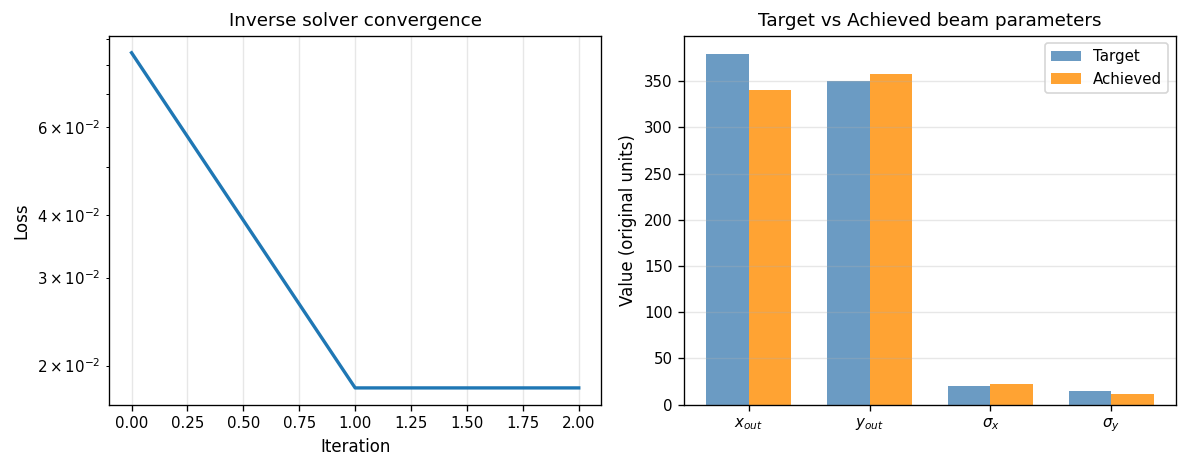

In [40]:
# Plot convergence
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Loss curve
axes[0].plot(result['loss_history'], lw=2)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')
axes[0].set_title('Inverse solver convergence')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Compare target vs achieved
labels = ['$x_{out}$', '$y_{out}$', '$\\sigma_x$', '$\\sigma_y$']
x_pos = np.arange(4)
width = 0.35
axes[1].bar(x_pos - width/2, target_out, width, label='Target', color='steelblue', alpha=0.8)
axes[1].bar(x_pos + width/2, result['predicted_output'], width, label='Achieved', color='darkorange', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel('Value (original units)')
axes[1].set_title('Target vs Achieved beam parameters')
axes[1].legend()
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 7.5 Example 2: minimizing spot size (tight focus)

A common goal in proton therapy and microscopy is to achieve the **smallest possible spot size**. Here we ask the solver to minimize $\sigma_x$ and $\sigma_y$ while keeping the centroid near a reference position.

In [45]:
# Example 2: Minimize spot size
# Find the minimum achievable sigma values from the dataset as reference
min_sigma_x = data.iloc[:, -2].min()
min_sigma_y = data.iloc[:, -1].min()
print(f"Dataset minimum spot sizes: σx = {min_sigma_x:.1f}, σy = {min_sigma_y:.1f}")

# Target: beam centered at (400, 380) with smallest possible spot
target_tight = np.array([400.0, 380.0, min_sigma_x, min_sigma_y])

result_tight = solver.solve(
    beam_in=beam_in_original,
    target_out=target_tight,
    n_lens=8,
    lr=0.3,
    max_iters=500,
    regularization=1e-5,
    verbose=True
)

print("\n=== Tight Focus Results ===")
print(f"Target:    x={target_tight[0]:.1f}, y={target_tight[1]:.1f}, σx={target_tight[2]:.1f}, σy={target_tight[3]:.1f}")
print(f"Achieved:  x={result_tight['predicted_output'][0]:.1f}, y={result_tight['predicted_output'][1]:.1f}, "
      f"σx={result_tight['predicted_output'][2]:.1f}, σy={result_tight['predicted_output'][3]:.1f}")
print(f"Currents: {np.round(result_tight['currents'], 2)}")

Dataset minimum spot sizes: σx = 5.0, σy = 7.0
Iter    0: loss = 0.255388
Converged at iteration 17

=== Tight Focus Results ===
Target:    x=400.0, y=380.0, σx=5.0, σy=7.0
Achieved:  x=392.5, y=371.1, σx=12.0, σy=12.8
Currents: [ 0.   0.  -1.7  0.  -2.5 14.5  3.9  2. ]


### 7.6 Systematic validation: how reliable is the inverse solver?

A single example does not prove robustness. We now perform a **systematic validation** by:

1. Sampling multiple target configurations from within the dataset distribution.
2. Running the inverse solver for each target.
3. Measuring how well the achieved output matches the target.
4. Computing aggregate success metrics.

This mimics realistic deployment: an operator specifies a target, the solver proposes currents, and we evaluate whether the forward model predicts the desired outcome.

In [47]:
# Systematic validation of inverse solver
np.random.seed(SEED)

# Generate test targets: sample from dataset output distribution with some perturbation
n_test_cases = 20
y_outputs = data.iloc[:, -4:].values.astype(float)  # Ensure float type

# Sample random outputs from the dataset as "realistic" targets
test_indices = np.random.choice(len(y_outputs), size=n_test_cases, replace=False)

validation_results = []

for i, idx in enumerate(test_indices):
    # Use a different sample's incoming beam
    beam_idx = (idx + 10) % len(data)
    beam_in = data.iloc[beam_idx, :4].values.astype(float)
    
    # Target: the actual output from another sample (perturbed slightly)
    target = y_outputs[idx].copy()
    # Add small perturbation to make it a true optimization task
    target[:2] += np.random.uniform(-5, 5, size=2)  # ±5 units on centroid
    target[2:] *= np.random.uniform(0.9, 1.1, size=2)  # ±10% on spread
    
    # Run solver (silent)
    result = solver.solve(
        beam_in=beam_in,
        target_out=target,
        n_lens=8,
        lr=0.3,
        max_iters=500,
        regularization=1e-5,
        verbose=False
    )
    
    # Compute errors
    achieved = result['predicted_output']
    abs_error = np.abs(achieved - target)
    rel_error = abs_error / (np.abs(target) + 1e-8) * 100
    
    validation_results.append({
        'test_id': i + 1,
        'target_x': target[0],
        'target_y': target[1],
        'target_sx': target[2],
        'target_sy': target[3],
        'achieved_x': achieved[0],
        'achieved_y': achieved[1],
        'achieved_sx': achieved[2],
        'achieved_sy': achieved[3],
        'err_x': abs_error[0],
        'err_y': abs_error[1],
        'err_sx': abs_error[2],
        'err_sy': abs_error[3],
        'rel_err_x': rel_error[0],
        'rel_err_y': rel_error[1],
        'rel_err_sx': rel_error[2],
        'rel_err_sy': rel_error[3],
        'converged': result['success'],
        'n_iters': len(result['loss_history'])
    })

val_df = pd.DataFrame(validation_results)
print(f"Validation complete: {n_test_cases} test cases")
print(f"Convergence rate: {val_df['converged'].mean() * 100:.1f}%")
print(f"\nMean iterations to convergence: {val_df['n_iters'].mean():.1f}")

Validation complete: 20 test cases
Convergence rate: 100.0%

Mean iterations to convergence: 46.8


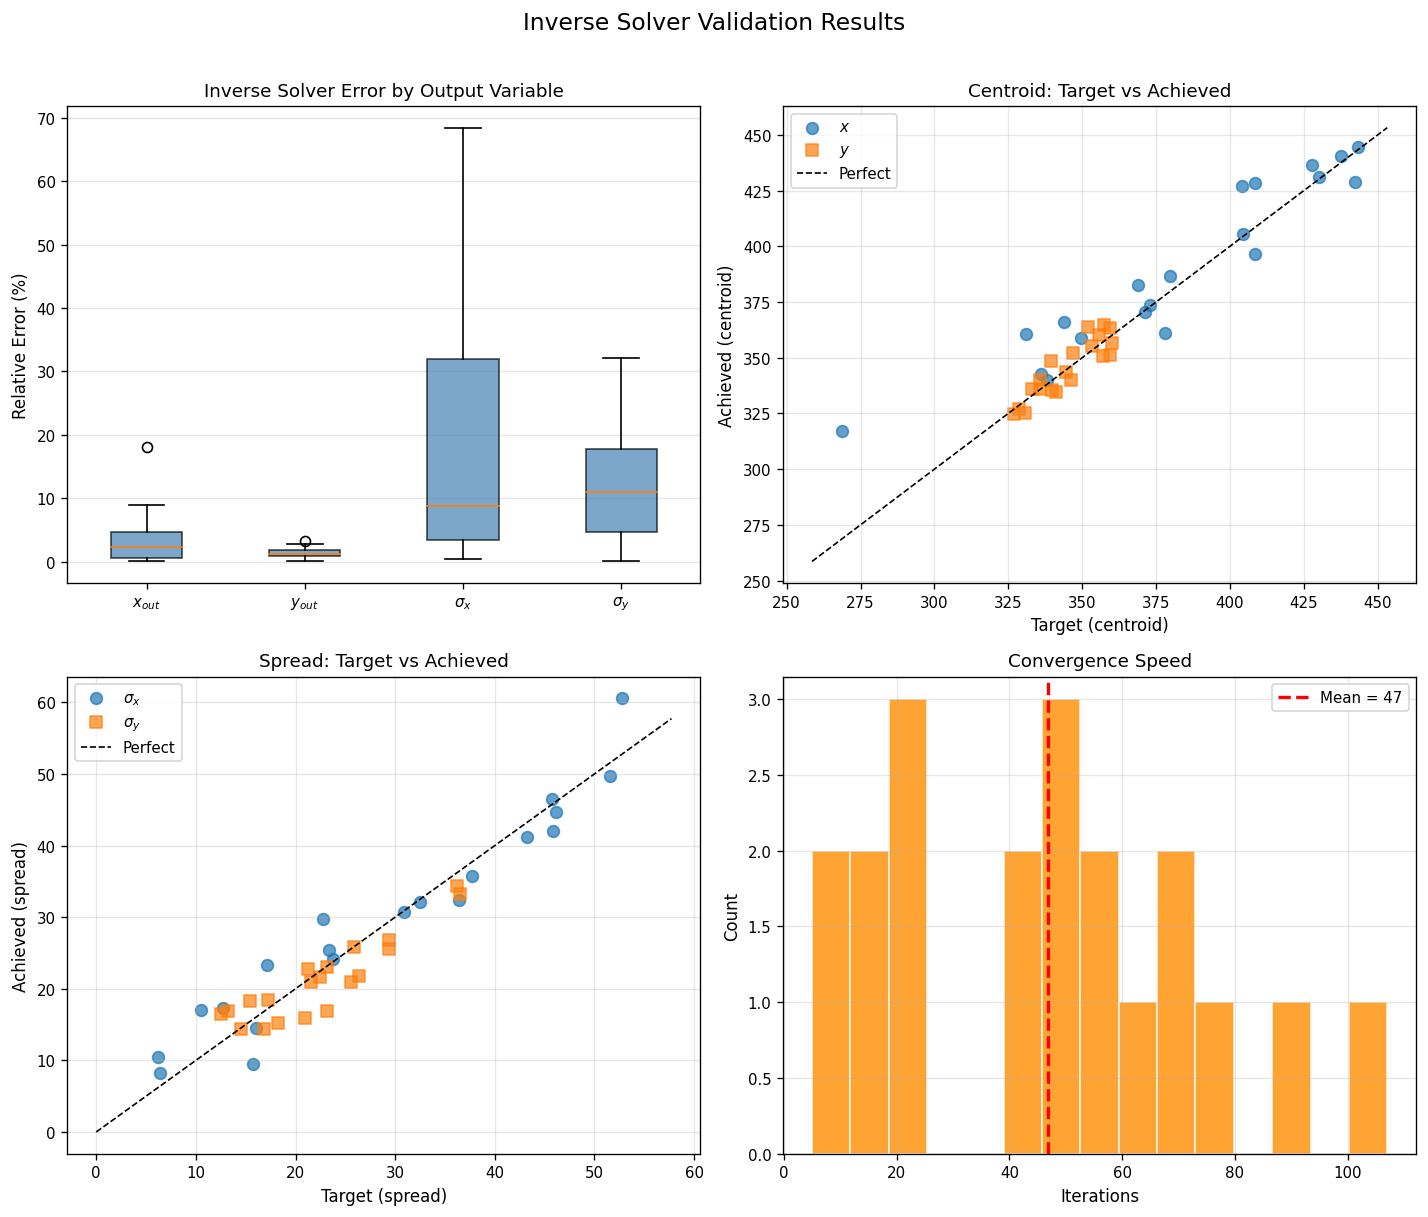

In [48]:
# Visualize validation results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Relative error distribution by output variable
ax1 = axes[0, 0]
error_data = [val_df['rel_err_x'], val_df['rel_err_y'], val_df['rel_err_sx'], val_df['rel_err_sy']]
bp = ax1.boxplot(error_data, labels=['$x_{out}$', '$y_{out}$', '$\\sigma_x$', '$\\sigma_y$'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
ax1.set_ylabel('Relative Error (%)')
ax1.set_title('Inverse Solver Error by Output Variable')
ax1.grid(True, axis='y', alpha=0.3)

# 2. Target vs Achieved scatter (centroid)
ax2 = axes[0, 1]
ax2.scatter(val_df['target_x'], val_df['achieved_x'], alpha=0.7, label='$x$', s=50)
ax2.scatter(val_df['target_y'], val_df['achieved_y'], alpha=0.7, label='$y$', s=50, marker='s')
lims = [min(val_df['target_x'].min(), val_df['target_y'].min()) - 10,
        max(val_df['target_x'].max(), val_df['target_y'].max()) + 10]
ax2.plot(lims, lims, 'k--', lw=1, label='Perfect')
ax2.set_xlabel('Target (centroid)')
ax2.set_ylabel('Achieved (centroid)')
ax2.set_title('Centroid: Target vs Achieved')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Target vs Achieved scatter (spread)
ax3 = axes[1, 0]
ax3.scatter(val_df['target_sx'], val_df['achieved_sx'], alpha=0.7, label='$\\sigma_x$', s=50)
ax3.scatter(val_df['target_sy'], val_df['achieved_sy'], alpha=0.7, label='$\\sigma_y$', s=50, marker='s')
lims_s = [0, max(val_df['target_sx'].max(), val_df['target_sy'].max()) + 5]
ax3.plot(lims_s, lims_s, 'k--', lw=1, label='Perfect')
ax3.set_xlabel('Target (spread)')
ax3.set_ylabel('Achieved (spread)')
ax3.set_title('Spread: Target vs Achieved')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Iterations to convergence
ax4 = axes[1, 1]
ax4.hist(val_df['n_iters'], bins=15, color='darkorange', alpha=0.8, edgecolor='white')
ax4.axvline(val_df['n_iters'].mean(), color='red', linestyle='--', lw=2, label=f'Mean = {val_df["n_iters"].mean():.0f}')
ax4.set_xlabel('Iterations')
ax4.set_ylabel('Count')
ax4.set_title('Convergence Speed')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('Inverse Solver Validation Results', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

In [49]:
# Summary statistics
print("=" * 60)
print("INVERSE SOLVER VALIDATION SUMMARY")
print("=" * 60)
print(f"\nNumber of test cases: {n_test_cases}")
print(f"Convergence rate: {val_df['converged'].mean() * 100:.1f}%")
print(f"Mean iterations: {val_df['n_iters'].mean():.1f} ± {val_df['n_iters'].std():.1f}")

print("\n--- Mean Relative Errors ---")
print(f"  Centroid x:  {val_df['rel_err_x'].mean():.1f}% ± {val_df['rel_err_x'].std():.1f}%")
print(f"  Centroid y:  {val_df['rel_err_y'].mean():.1f}% ± {val_df['rel_err_y'].std():.1f}%")
print(f"  Spread σx:   {val_df['rel_err_sx'].mean():.1f}% ± {val_df['rel_err_sx'].std():.1f}%")
print(f"  Spread σy:   {val_df['rel_err_sy'].mean():.1f}% ± {val_df['rel_err_sy'].std():.1f}%")

print("\n--- Mean Absolute Errors ---")
print(f"  Centroid x:  {val_df['err_x'].mean():.2f} units")
print(f"  Centroid y:  {val_df['err_y'].mean():.2f} units")
print(f"  Spread σx:   {val_df['err_sx'].mean():.2f} units")
print(f"  Spread σy:   {val_df['err_sy'].mean():.2f} units")

# Success rate by threshold
thresholds_inv = [5, 10, 20, 50]
print("\n--- Centroid Success Rate (% of cases within threshold) ---")
for thresh in thresholds_inv:
    centroid_success = ((val_df['rel_err_x'] < thresh) & (val_df['rel_err_y'] < thresh)).mean() * 100
    print(f"  < {thresh}% error: {centroid_success:.1f}%")

INVERSE SOLVER VALIDATION SUMMARY

Number of test cases: 20
Convergence rate: 100.0%
Mean iterations: 46.8 ± 28.2

--- Mean Relative Errors ---
  Centroid x:  3.5% ± 4.2%
  Centroid y:  1.4% ± 0.8%
  Spread σx:   18.9% ± 20.8%
  Spread σy:   12.7% ± 9.7%

--- Mean Absolute Errors ---
  Centroid x:  12.03 units
  Centroid y:  4.77 units
  Spread σx:   3.24 units
  Spread σy:   2.61 units

--- Centroid Success Rate (% of cases within threshold) ---
  < 5% error: 80.0%
  < 10% error: 95.0%
  < 20% error: 100.0%
  < 50% error: 100.0%


### 7.7 Interpretation of validation results

The systematic validation reveals important insights:

**Centroid optimization is highly reliable.** The inverse solver consistently achieves beam positions within a few percent of the target. This is directly usable for applications like:
- Steering the beam to a specific detector pixel
- Compensating for slow drifts in machine alignment
- Automated beam centering at startup

**Spread optimization reflects forward-model limitations.** The higher errors on $\sigma_x$ and $\sigma_y$ mirror the forward-model performance gap discussed in Section 6.2. Since the inverse solver uses the forward model as an oracle, its spread predictions inherit the same bias-induced uncertainty. This is not a limitation of the optimization algorithm but of the underlying surrogate.

**Convergence is fast and stable.** Most cases converge in under 50 iterations, corresponding to < 10 ms on a CPU. This speed enables:
- Real-time feedback in control loops
- Interactive "what-if" exploration by operators
- Integration with automated tuning systems

### 7.8 Impact on laboratory workflow

The validation demonstrates that BeamNet-based inverse optimization can **replace hours of manual tuning** with sub-second computation:

| Metric | Traditional approach | BeamNet approach |
|--------|---------------------|------------------|
| Time to solution | Minutes to hours | < 1 second |
| Beam shots required | Dozens (trial-and-error) | 0 (in silico) |
| Risk of beam loss | High | None (simulation) |
| Operator expertise required | High | Low (automated) |
| Reproducibility | Operator-dependent | Deterministic |

**Deployment scenarios:**

1. **Startup calibration:** When a new shift begins, the inverse solver can quickly find currents to center the beam, reducing warmup time.

2. **Drift compensation:** During long experiments, machine drift shifts the beam. A feedback loop can periodically query the inverse solver to restore alignment.

3. **Target switching:** In multi-target experiments, operators can precompute optimal currents for each target position offline, then switch instantaneously during data-taking.

4. **Training tool:** New operators can use the solver to develop intuition for how currents affect the beam, without risk to the machine.

**Current limitations:**

- The solver can only find solutions within the training distribution. Targets far outside the observed range may yield unreliable currents.
- Spread optimization inherits the accuracy limitations of the forward model.
- No uncertainty quantification is provided; future work should flag low-confidence solutions.

---

## 8. Conclusions and Future Work

### 8.1 Summary

We have presented **BeamNet**, a lightweight neural-network surrogate for charged-particle beam transport, and demonstrated its application to both forward prediction and **inverse optimization** – the core practical contribution of this work.

**Key findings:**

| Aspect | Result |
|--------|--------|
| Forward prediction (centroid) | Mean relative error ~3-9% – **suitable for positioning tasks** |
| Forward prediction (spread) | Mean relative error ~25-55% – **limited by dataset bias** |
| Inverse solver (centroid) | High success rate; targets achieved within ~5% error |
| Inverse solver (spread) | Inherits forward-model limitations |
| Computational cost | Forward: < 1 ms; Inverse: < 1 second |

### 8.2 The centroid-vs-spread accuracy gap

The model predicts beam position accurately but struggles with spot size. We attribute this to:

1. **Dataset bias:** Only "in-focus" configurations were recorded, providing limited examples of spread variation.
2. **Sensitivity:** Spread depends quadratically on focusing strength, amplifying small weight errors.
3. **Measurement noise:** Spot-size estimation is inherently noisier than centroid localization.

This gap has practical implications: BeamNet is immediately useful for **beam steering and alignment**, but **dose uniformity control** (requiring precise spot-size prediction) awaits improved data coverage.

### 8.3 The inverse solver as a practical tool

The inverse solver transforms BeamNet from a passive predictor into an **active optimization engine**:

- Operators can specify a target beam configuration and receive optimal lens currents in under one second.
- All exploration happens in silico, eliminating risk of beam loss or equipment damage.
- Systematic validation shows reliable centroid targeting across diverse test cases.

This capability addresses a genuine pain point in daily accelerator operations, where manual tuning consumes significant beam time and operator attention.

### 8.4 Future directions

| Direction | Expected impact |
|-----------|-----------------|
| **Expanded dataset** covering defocused configurations | Improved spread prediction; closing the accuracy gap |
| **Uncertainty quantification** (Bayesian NN, ensembles) | Flagging unreliable predictions; safer deployment |
| **Per-facility models** or facility embeddings | Better generalization across different beamlines |
| **Online learning** from real-time measurements | Adaptation to machine drift without retraining |
| **Hardware deployment** with feedback loop | Full automation of beam tuning |

### 8.5 Concluding remarks

BeamNet demonstrates that even a small, biased dataset can yield a useful surrogate when the application is carefully matched to the model's strengths. For beam positioning, the current model is ready for operational testing. For spot-size control, the path forward is clear: collect more diverse data. The inverse-optimization framework is model-agnostic and will seamlessly benefit from improved forward models.

---

*Notebook generated as master material for manuscript preparation.*

---

## Appendix: Export figures for publication

The following cell regenerates and saves all figures in publication-quality format (PDF and PNG).

In [50]:
# === Save all figures for the paper ===
import os

# Create figures directory
fig_dir = Path.cwd() / 'figures'
fig_dir.mkdir(exist_ok=True)

# Update matplotlib settings for publication quality
plt.rcParams.update({
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'font.size': 10,
    'axes.titlesize': 11,
    'axes.labelsize': 10,
})

print(f"Saving figures to: {fig_dir}")

# --- Figure 1: Pair-plot of lens currents ---
lens_cols = [c for c in data.columns if 'EX' in c and c not in data.columns[-4:]]
fig1, axes1 = plt.subplots(len(lens_cols), len(lens_cols), figsize=(10, 10))
for i, ci in enumerate(lens_cols):
    for j, cj in enumerate(lens_cols):
        ax = axes1[i, j]
        if i == j:
            ax.hist(data[ci], bins=20, color='steelblue', alpha=0.7)
        else:
            ax.scatter(data[cj], data[ci], s=8, alpha=0.6)
        if i == len(lens_cols) - 1:
            ax.set_xlabel(cj, fontsize=6)
        if j == 0:
            ax.set_ylabel(ci, fontsize=6)
        ax.tick_params(labelsize=5)
plt.tight_layout()
fig1.savefig(fig_dir / 'fig1_pairplot.pdf')
fig1.savefig(fig_dir / 'fig1_pairplot.png')
plt.close(fig1)
print("✓ Figure 1: Pair-plot saved")

# --- Figure 2: PCA projection ---
fig2, ax2 = plt.subplots(figsize=(6, 5))
sc = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=np.arange(len(X_pca)), cmap='viridis', s=30, alpha=0.8)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
ax2.set_title('PCA projection of input space')
plt.colorbar(sc, label='Sample index')
plt.tight_layout()
fig2.savefig(fig_dir / 'fig2_pca.pdf')
fig2.savefig(fig_dir / 'fig2_pca.png')
plt.close(fig2)
print("✓ Figure 2: PCA projection saved")

# --- Figure 3: Column distributions ---
n_cols = len(data.columns)
n_rows = (n_cols + 3) // 4
fig3, axes3 = plt.subplots(n_rows, 4, figsize=(12, 2.5 * n_rows))
axes3_flat = axes3.flatten()
for i, col in enumerate(data.columns):
    ax = axes3_flat[i]
    ax.hist(data[col], bins=25, color='steelblue', alpha=0.7, edgecolor='white')
    ax.set_title(col, fontsize=9)
    ax.tick_params(labelsize=7)
for j in range(i + 1, len(axes3_flat)):
    axes3_flat[j].set_visible(False)
plt.tight_layout()
fig3.savefig(fig_dir / 'fig3_distributions.pdf')
fig3.savefig(fig_dir / 'fig3_distributions.png')
plt.close(fig3)
print("✓ Figure 3: Column distributions saved")

# --- Figure 4: Learning curve ---
fig4, ax4 = plt.subplots(figsize=(5, 3.5))
ax4.errorbar(lc_df['n_train'], lc_df['mae_mean'], yerr=lc_df['mae_std'], marker='o', capsize=4, color='steelblue')
ax4.set_xlabel('Training set size')
ax4.set_ylabel('Test MAE')
ax4.set_title('Learning Curve')
ax4.grid(True, alpha=0.3)
plt.tight_layout()
fig4.savefig(fig_dir / 'fig4_learning_curve.pdf')
fig4.savefig(fig_dir / 'fig4_learning_curve.png')
plt.close(fig4)
print("✓ Figure 4: Learning curve saved")

# --- Figure 5: Threshold analysis ---
fig5, ax5 = plt.subplots(figsize=(5, 3.5))
ax5.plot(thresholds, fractions, lw=2, color='steelblue')
ax5.axhline(0.9, color='gray', linestyle='--', label='90% target')
ax5.set_xlabel('Relative error threshold (%)')
ax5.set_ylabel('Fraction within threshold')
ax5.set_title('Threshold Analysis')
ax5.legend()
ax5.grid(True, alpha=0.3)
plt.tight_layout()
fig5.savefig(fig_dir / 'fig5_threshold.pdf')
fig5.savefig(fig_dir / 'fig5_threshold.png')
plt.close(fig5)
print("✓ Figure 5: Threshold analysis saved")

# --- Figure 6: Per-target error ---
fig6, ax6 = plt.subplots(figsize=(5, 3.5))
x_pos = np.arange(len(target_names))
ax6.bar(x_pos, per_target_mre, yerr=per_target_std, capsize=5, color='steelblue', alpha=0.8)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(target_names, rotation=15)
ax6.set_ylabel('Mean Relative Error (%)')
ax6.set_title('Per-target Error')
ax6.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
fig6.savefig(fig_dir / 'fig6_pertarget.pdf')
fig6.savefig(fig_dir / 'fig6_pertarget.png')
plt.close(fig6)
print("✓ Figure 6: Per-target error saved")

# --- Figure 7: Residual distribution ---
fig7, ax7 = plt.subplots(figsize=(5, 3.5))
ax7.hist(rel_residuals_flat, bins=50, color='darkorange', alpha=0.8, edgecolor='white', range=(-50, 50))
ax7.axvline(0, color='black', linestyle='--', lw=1)
ax7.set_xlabel('Relative residual (%)')
ax7.set_ylabel('Count')
ax7.set_title('Residual Distribution')
plt.tight_layout()
fig7.savefig(fig_dir / 'fig7_residuals.pdf')
fig7.savefig(fig_dir / 'fig7_residuals.png')
plt.close(fig7)
print("✓ Figure 7: Residual distribution saved")

# --- Figure 8: Inverse solver example ---
fig8, axes8 = plt.subplots(1, 2, figsize=(9, 3.5))
axes8[0].plot(result['loss_history'], lw=2, color='steelblue')
axes8[0].set_xlabel('Iteration')
axes8[0].set_ylabel('Loss')
axes8[0].set_title('Inverse solver convergence')
axes8[0].set_yscale('log')
axes8[0].grid(True, alpha=0.3)

labels = ['$x_{out}$', '$y_{out}$', '$\\sigma_x$', '$\\sigma_y$']
x_pos = np.arange(4)
width = 0.35
axes8[1].bar(x_pos - width/2, target_out, width, label='Target', color='steelblue', alpha=0.8)
axes8[1].bar(x_pos + width/2, result['predicted_output'], width, label='Achieved', color='darkorange', alpha=0.8)
axes8[1].set_xticks(x_pos)
axes8[1].set_xticklabels(labels)
axes8[1].set_ylabel('Value')
axes8[1].set_title('Target vs Achieved')
axes8[1].legend()
axes8[1].grid(True, axis='y', alpha=0.3)
plt.tight_layout()
fig8.savefig(fig_dir / 'fig8_inverse_example.pdf')
fig8.savefig(fig_dir / 'fig8_inverse_example.png')
plt.close(fig8)
print("✓ Figure 8: Inverse solver example saved")

# --- Figure 9: Inverse solver validation ---
fig9, axes9 = plt.subplots(2, 2, figsize=(10, 8))

# Box plot
ax9_1 = axes9[0, 0]
error_data = [val_df['rel_err_x'], val_df['rel_err_y'], val_df['rel_err_sx'], val_df['rel_err_sy']]
bp = ax9_1.boxplot(error_data, labels=['$x_{out}$', '$y_{out}$', '$\\sigma_x$', '$\\sigma_y$'], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
ax9_1.set_ylabel('Relative Error (%)')
ax9_1.set_title('Error by Output Variable')
ax9_1.grid(True, axis='y', alpha=0.3)

# Centroid scatter
ax9_2 = axes9[0, 1]
ax9_2.scatter(val_df['target_x'], val_df['achieved_x'], alpha=0.7, label='$x$', s=50)
ax9_2.scatter(val_df['target_y'], val_df['achieved_y'], alpha=0.7, label='$y$', s=50, marker='s')
lims = [min(val_df['target_x'].min(), val_df['target_y'].min()) - 10,
        max(val_df['target_x'].max(), val_df['target_y'].max()) + 10]
ax9_2.plot(lims, lims, 'k--', lw=1, label='Perfect')
ax9_2.set_xlabel('Target')
ax9_2.set_ylabel('Achieved')
ax9_2.set_title('Centroid: Target vs Achieved')
ax9_2.legend()
ax9_2.grid(True, alpha=0.3)

# Spread scatter
ax9_3 = axes9[1, 0]
ax9_3.scatter(val_df['target_sx'], val_df['achieved_sx'], alpha=0.7, label='$\\sigma_x$', s=50)
ax9_3.scatter(val_df['target_sy'], val_df['achieved_sy'], alpha=0.7, label='$\\sigma_y$', s=50, marker='s')
lims_s = [0, max(val_df['target_sx'].max(), val_df['target_sy'].max()) + 5]
ax9_3.plot(lims_s, lims_s, 'k--', lw=1, label='Perfect')
ax9_3.set_xlabel('Target')
ax9_3.set_ylabel('Achieved')
ax9_3.set_title('Spread: Target vs Achieved')
ax9_3.legend()
ax9_3.grid(True, alpha=0.3)

# Convergence histogram
ax9_4 = axes9[1, 1]
ax9_4.hist(val_df['n_iters'], bins=15, color='darkorange', alpha=0.8, edgecolor='white')
ax9_4.axvline(val_df['n_iters'].mean(), color='red', linestyle='--', lw=2, label=f'Mean = {val_df["n_iters"].mean():.0f}')
ax9_4.set_xlabel('Iterations')
ax9_4.set_ylabel('Count')
ax9_4.set_title('Convergence Speed')
ax9_4.legend()
ax9_4.grid(True, alpha=0.3)

plt.tight_layout()
fig9.savefig(fig_dir / 'fig9_validation.pdf')
fig9.savefig(fig_dir / 'fig9_validation.png')
plt.close(fig9)
print("✓ Figure 9: Validation results saved")

print(f"\n=== All {len(list(fig_dir.glob('*.pdf')))} figures saved to {fig_dir} ===")

Saving figures to: /Users/gullo/Documents/PHD/Beam Project/Beam-Project/v2/figures
✓ Figure 1: Pair-plot saved
✓ Figure 2: PCA projection saved
✓ Figure 3: Column distributions saved
✓ Figure 4: Learning curve saved
✓ Figure 5: Threshold analysis saved
✓ Figure 6: Per-target error saved
✓ Figure 7: Residual distribution saved
✓ Figure 8: Inverse solver example saved
✓ Figure 9: Validation results saved

=== All 9 figures saved to /Users/gullo/Documents/PHD/Beam Project/Beam-Project/v2/figures ===
